Regression of noisy data:
$$y = f_{\theta}(x) + \epsilon,$$
using a deep neural network $f_{\theta}(x)$.

In [75]:
!pip install --upgrade neural_tangents

Requirement already up-to-date: neural_tangents in /usr/local/lib/python3.7/dist-packages (0.3.6)


In [76]:
import jax.numpy as np
from jax import random, jit, grad, vmap, jacobian, eval_shape
from jax.example_libraries import optimizers

import neural_tangents as nt
from jax.tree_util import tree_reduce
from jax.tree_util import tree_multimap
from jax.flatten_util import ravel_pytree
import operator

import itertools
from functools import partial
from tqdm import trange
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [77]:
def MLP(layers, activation=np.tanh):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev*random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params
    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b
        return outputs
    return init, apply

def FF_MLP(layers, freq, activation=np.tanh):
   # Define input encoding function
    def input_encoding(x, w):
        out = np.hstack([np.sin(np.dot(x, w)),
                         np.cos(np.dot(x, w))])
        return out
    FF = freq * random.normal(random.PRNGKey(0), (layers[0], layers[1]//2))
    def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[1:-1], layers[2:]))
      return params
    def apply(params, inputs):
        H = input_encoding(inputs, FF)
        for W, b in params[:-1]:
            outputs = np.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(H, W) + b
        return outputs
    return init, apply

In [78]:
# Helper function for computing the Jacobians dot product with PyTrees
def sum_and_contract(j1, j2, output_ndim):
    _diagonal_axes = nt.utils.utils.canonicalize_axis((), output_ndim)
    _trace_axes = nt.utils.utils.canonicalize_axis((-1,), output_ndim)
    def contract(x, y):
        param_axes = list(range(x.ndim))[output_ndim:]
        contract_axes = _trace_axes + param_axes
        return nt.utils.utils.dot_general(x, y, contract_axes, _diagonal_axes)
    return tree_reduce(operator.add, tree_multimap(contract, j1, j2))

# computes the NTK: <jac(f1)(x1), jac(f2)(x2)>
def compute_ntk(f1, f2, x1, x2, params):
    j1 = jacobian(f1)(params, x1)
    j2 = jacobian(f2)(params, x2)
    fx1 = eval_shape(f1, params, x1)
    ntk = sum_and_contract(j1, j2, fx1.ndim)
    return ntk

In [79]:
class NeuralNetRegression():
    def __init__(self, X, y, layers, rng_key = random.PRNGKey(0)):
        # Normalize data
        self.Xmean, self.Xstd = X.mean(0), X.std(0)
        self.Ymean, self.Ystd = y.mean(0), y.std(0)
        X = (X - self.Xmean)/self.Xstd
        y = (y - self.Ymean)/self.Ystd

        # Store the normalized trainind data
        self.X = X
        self.y = y

        # Initialization and evaluation functions
        # self.net_init, self.net_apply = MLP(layers)
        self.net_init, self.net_apply = FF_MLP(layers, 10.0)
        
        # Initialize parameters, not committing to a batch shape
        self.net_params = self.net_init(rng_key)
                    
        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(1e-3)
        self.opt_state = self.opt_init(self.net_params)

        # Logger to monitor the loss function
        self.loss_log = []
        self.itercount = itertools.count()

    def per_example_loss(self, params, batch):
        X, y = batch
        y_pred = self.net_apply(params, X)
        loss = (y - y_pred)**2
        return loss

    def loss(self, params, batch):
        pe_loss = lambda x: self.per_example_loss(params, x)
        loss = 0.5*np.sum(vmap(pe_loss)(batch))
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    def data_stream(self, n, num_batches, batch_size):
        rng = npr.RandomState(0)
        while True:
            perm = rng.permutation(n)
            for i in range(num_batches):
                batch_idx = perm[i*batch_size:(i+1)*batch_size]
                yield self.X[batch_idx, :], self.y[batch_idx]

    def train(self, num_epochs = 100, batch_size = 64):   
        # Build a data iterator
        n = self.X.shape[0]
        num_complete_batches, leftover = divmod(n, batch_size)
        num_batches = num_complete_batches + bool(leftover) 
        batch = iter(self.data_stream(n, num_batches, batch_size))
        # Run training loop
        pbar = trange(num_epochs)
        for epoch in pbar:
            for _ in range(num_batches):
                self.opt_state = self.step(next(self.itercount), self.opt_state, next(batch))
            self.net_params = self.get_params(self.opt_state)
            loss_value = self.loss(self.net_params, next(batch))
            self.loss_log.append(loss_value)
            pbar.set_postfix({'Loss': loss_value})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, X_star):
        X_star = (X_star - self.Xmean)/self.Xstd
        pred_fn = lambda x: self.net_apply(params, x)
        y_pred = vmap(pred_fn)(X_star)
        y_pred = y_pred*self.Ystd + self.Ymean
        return y_pred

    def compute_activations(self, params, X_star):
        X_star = (X_star - self.Xmean)/self.Xstd
        def _apply(params, inputs):
            activations = []
            for W, b in params[:-1]:
                outputs = np.dot(inputs, W) + b
                inputs = np.tanh(outputs)
                activations.append(inputs)
            return activations
        # Get activations
        pred_fn = lambda x: _apply(params, x)
        activations = vmap(pred_fn)(X_star)
        return activations

    @partial(jit, static_argnums=(0,))
    def compute_NTK_spectrum(self, params, X_star):
        X_star = (X_star - self.Xmean)/self.Xstd
        f_fn = lambda p, x: vmap(self.net_apply, in_axes=(None,0))(p, x)
        # Construct NKT operator
        K = compute_ntk(f_fn, f_fn, X_star, X_star, params)
        # Spectral decomposition
        v, w = np.linalg.eigh(K)
        # Sort eigenvalues
        idx = np.argsort(v)[::-1]
        evals = v[idx]
        evecs = w[:,idx]
        return evals, evecs

In [80]:
def f(x):
    return np.sin(20.0*np.pi*x)

In [81]:
rng_key = random.PRNGKey(0)

d = 1
n = 500
lb = 0.0*np.ones(d)
ub = 1.0*np.ones(d)
noise = 0.1

# Create training data
X = lb + (ub-lb)*random.uniform(rng_key, (n, d))
y = vmap(f)(X)
y = y + noise*y.std(0)*npr.randn(n,1)

# Create test data
X_star = np.linspace(lb, ub, 512)
y_star = vmap(f)(X_star)

In [82]:
layers = [1, 128, 128, 1]
model = NeuralNetRegression(X, y, layers, rng_key)

In [83]:
model.train(num_epochs=2000, batch_size=128)

100%|██████████| 2000/2000 [01:20<00:00, 24.74it/s, Loss=0.52505434]


In [84]:
# Test predictions
opt_params = model.get_params(model.opt_state)
y_pred = model.predict(opt_params, X_star)
error = np.linalg.norm(y_star-y_pred, 2)/np.linalg.norm(y_star, 2)
print('Relative L2 error: %e' % (error))

Relative L2 error: 5.398807e-02


In [85]:
# NTK spectrum
evals, evecs = model.compute_NTK_spectrum(opt_params, X_star)

In [86]:
print(evecs.shape)

(512, 512)


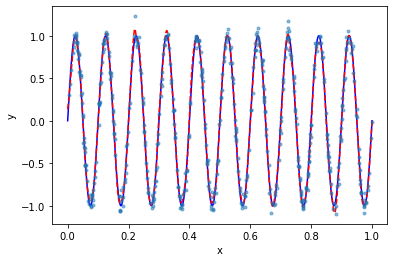

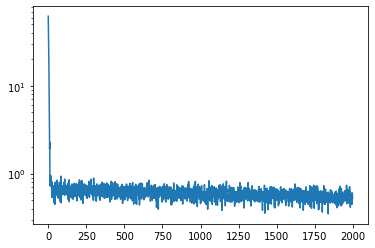

In [87]:
# Plotting
fig = plt.figure()
plt.plot(X_star, y_star, 'b')
plt.plot(X_star, y_pred, 'r--')
plt.plot(X, y, '.', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')

plt.figure()
plt.plot(model.loss_log)
plt.yscale('log')

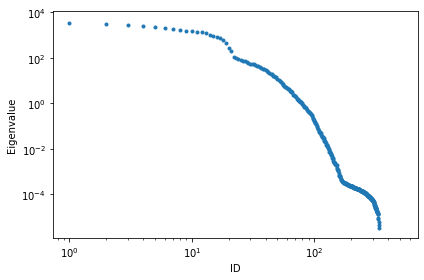

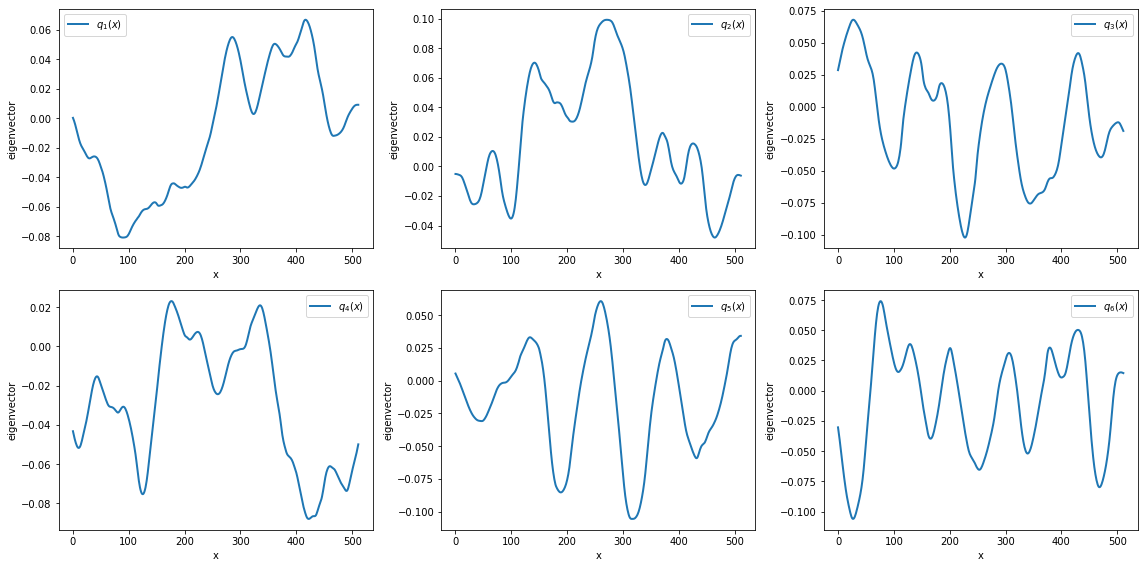

In [88]:
plt.figure()
plt.plot(evals, '.')
plt.xlabel('ID')
plt.ylabel('Eigenvalue')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

plt.figure(figsize = (16,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(evecs[:,i], lw = 2, label='$q_{%d}(x)$' % (i+1))
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('eigenvector')
plt.tight_layout()